In [209]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim

In [210]:
imageset = np.empty((7704,64,64,3), dtype='float32')

#There are 7704 images in the dataset.
#214 folders. Each having 36 images.
rootdir = '/home/chinmay/CODE/deep_learning/shapenet_datasets/mug_unprocessed/mug/models/3dw'
cnt = 0
total_cnt = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith('.png'):
            if cnt == 36:
                cnt = 0
                total_cnt += 1
            cnt += 1
            seq_number = int(filepath.split('-')[-1].split('.')[0])
            
            imageset[total_cnt*36 + seq_number] = misc.imread(filepath).astype(np.float32)

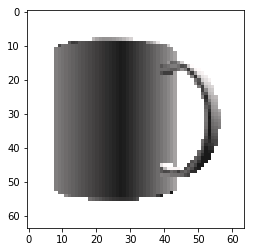

In [211]:
#this part is to visulize image
tmp = imageset[3569]
#print tmp.shape
plt.imshow(tmp/255)
plt.show()

In [212]:
data_ = np.zeros(imageset.shape)
labels_ = np.zeros(imageset.shape)
pose = np.zeros((7704,8,8,36))



for cnt in range(214):
    for itr in range(36):
        data_[(cnt*36) + itr] = imageset[cnt*36]
        pose_tmp = np.zeros(36)
        pose_tmp[itr] = 1
        pose[(cnt*36) + itr] = np.broadcast_to(pose_tmp,(8,8,36))
        labels_[(cnt*36) + itr] =  imageset[(cnt*36) + itr]
        #print( (cnt*36) + itr)

data_, labels_, pose = shuffle(data_, labels_, pose, random_state=0)
#This code will generate labels for the dataset
#perm = np.random.permutation(data_.shape[0])

# data_ = data_[perm]
# labels_ = labels_[perm]
# pose = pose[perm]

# For current image label is the next image (image with 10 degree rotation)
# For last image in the set (36th image) label would be first image
data_train = np.array(data_[:6120])
data_test = np.array(data_[6120:])

train_labels = np.array(labels_[:6120])
test_labels = np.array(labels_[6120:])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


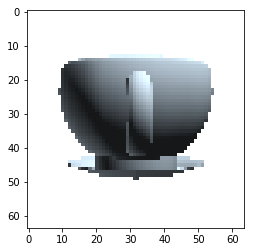

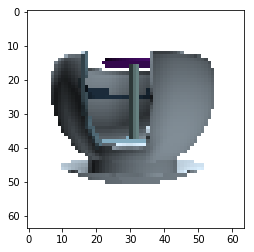

In [213]:
tmp = train_labels[5][...,::-1]
tmp1 = data_train[5][...,::-1]

print(pose[100][0][0])
plt.imshow(tmp1/255)
plt.show()
plt.imshow(tmp/255)
plt.show()

In [214]:
#normalize data


#data_train *= 2
data_train /= 255
#data_train -= 1

#data_test *= 2
data_test /= 255
#data_test -= 1


#train_labels *= 2
train_labels /= 255
#train_labels -= 1

#test_labels *= 2
test_labels /= 255
#test_labels -= 1

In [215]:
def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=tf.nn.leaky_relu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=tf.nn.leaky_relu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)
    

In [260]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [261]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, 8, 8, 36), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [None, 1])
fake_label = tf.placeholder(tf.float32, [None, 1])

In [262]:

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):
    print(inputs_)
    with tf.variable_scope('encoder'):
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=tf.nn.leaky_relu)
        #_ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=tf.nn.leaky_relu)
        #_ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=tf.nn.leaky_relu)
        _ = tf.concat([_, pose_], 3)

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv1',act=tf.nn.leaky_relu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv2',act=tf.nn.leaky_relu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv3',act=tf.nn.leaky_relu)
    return _ 
    
    
# discriminator should give a fc layer
def discriminator(inputs_):
    with tf.variable_scope('dis', reuse = tf.AUTO_REUSE):
        ''' 
        _ = conv2d(inputs_, 4, 2, 32, 'conv1')
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 64, 'conv2')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 128, 'conv3')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = tf.reshape(_, [-1, 4 * 4 * 128])
        _ = fc(_, 1, 'fc4')
        print(_.get_shape(), "FC - Result")
        '''
        
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv1", act=tf.nn.leaky_relu)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv2", act=tf.nn.leaky_relu)
        # _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv3", act=tf.nn.leaky_relu)
        #_ = batch_norm(_, True)
        _ = tf.reshape(_, [-1, 8 * 8 * 32])        
        _ = fc(_, 1, 'dis_fc1')
        return _
        
    

In [263]:

global_step = tf.Variable(0,trainable=False)
lr = 1e-4


In [264]:
alpha = 1
beta = 1

generated_images = auto_encoder(inputs_, pose_)
g = discriminator(generated_images)

gen_loss_op = alpha * ce_loss(real_label, g) #+ beta * l1_loss(generated_images, targets_)
dis_loss_op = ce_loss(fake_label, g) + ce_loss(real_label, discriminator(disc_inputs))

 

Tensor("input:0", shape=(36, 64, 64, 3), dtype=float32)


In [265]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
print (generator_vars)
dis_optimizer = tf.train.RMSPropOptimizer(lr)
dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

gen_optimizer = tf.train.RMSPropOptimizer(lr)
gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

[<tf.Variable 'encoder/conv1/Conv/weights:0' shape=(3, 3, 3, 16) dtype=float32_ref>, <tf.Variable 'encoder/conv1/Conv/biases:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'encoder/conv2/Conv/weights:0' shape=(3, 3, 16, 32) dtype=float32_ref>, <tf.Variable 'encoder/conv2/Conv/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'encoder/conv3/Conv/weights:0' shape=(3, 3, 32, 92) dtype=float32_ref>, <tf.Variable 'encoder/conv3/Conv/biases:0' shape=(92,) dtype=float32_ref>, <tf.Variable 'encoder/deconv1/Conv2d_transpose/weights:0' shape=(3, 3, 32, 128) dtype=float32_ref>, <tf.Variable 'encoder/deconv1/Conv2d_transpose/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'encoder/deconv2/Conv2d_transpose/weights:0' shape=(3, 3, 16, 32) dtype=float32_ref>, <tf.Variable 'encoder/deconv2/Conv2d_transpose/biases:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'encoder/deconv3/Conv2d_transpose/weights:0' shape=(3, 3, 3, 16) dtype=float32_ref>, <tf.Variable 'encoder/deconv3/Conv2d_transpos

In [266]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 5
total_images = 6120
step = 0

r = total_images // batch_size

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        zeros = np.zeros([batch_size, 1])
        ones = np.ones([batch_size, 1])
        
        batch = data_train[ii*batch_size : (ii+1)*batch_size]
        batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        pose_labels = pose[ii*batch_size : (ii+1)*batch_size]
        
        
        k = np.random.randint(1,r)
        #print("K", k)
        
        d_inputs = data_train[k*batch_size : (k+1)*batch_size]
        
        
        

        gen_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         real_label: ones}

        _, gen_loss = sess.run([gen_train_op, gen_loss_op], feed_dict = gen_feed_dict)
        
        
        dis_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         fake_label: zeros, real_label: ones, disc_inputs: d_inputs}

        _, dis_loss = sess.run([dis_train_op, dis_loss_op], feed_dict = dis_feed_dict)

        if step % 10 == 0:
            print('Iteration {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(step, dis_loss, gen_loss))


Iteration 10: dis loss = 1.3855, gen loss = 0.6932
Iteration 20: dis loss = 1.3853, gen loss = 0.6932
Iteration 30: dis loss = 1.3851, gen loss = 0.6933
Iteration 40: dis loss = 1.3849, gen loss = 0.6935
Iteration 50: dis loss = 1.3845, gen loss = 0.6938
Iteration 60: dis loss = 1.3839, gen loss = 0.6942
Iteration 70: dis loss = 1.3832, gen loss = 0.6947
Iteration 80: dis loss = 1.3822, gen loss = 0.6953
Iteration 90: dis loss = 1.3804, gen loss = 0.6960
Iteration 100: dis loss = 1.3770, gen loss = 0.6971
Iteration 110: dis loss = 1.3693, gen loss = 0.6991
Iteration 120: dis loss = 1.3505, gen loss = 0.7027
Iteration 130: dis loss = 1.3046, gen loss = 0.7083
Iteration 140: dis loss = 1.2172, gen loss = 0.7167
Iteration 150: dis loss = 1.0785, gen loss = 0.7281
Iteration 160: dis loss = 0.9221, gen loss = 0.7442
Iteration 170: dis loss = 0.7925, gen loss = 0.7645
Iteration 180: dis loss = 0.6806, gen loss = 0.7914
Iteration 190: dis loss = 0.6158, gen loss = 0.8275
Iteration 200: dis lo